# ML Models with Sampled NYC Taxi Trip and Fare Dataset 

##### Here we show some features and capabilities of Spark's MLlib toolkit for ML problems using the NYC taxi trip and fare data-set from 2013. We take a 0.1% sample of this data-set (about 170K rows) to to show MLlib's modeling features for binary classification and regression problems using this data-set. We have shown relevant plots in Python.

OBJECTIVE: Show use of MLlib's functions for ML tasks on a small dataset (~35 Mb).

ORGANIZATION: We have organized this walkthrough into 5 major sections: 
1. Data ingestion
2. Data exploration and visualization
3. Data preparation, including feature transformation
4. Modeling: binary classification problem (tipped: 1/0), regression problem (tip amount $) 
6. Saving or persisting models in blob for future consumption

Majority of the modeling examples are shown for the binary classification problem. We have added simpler examples for the regression task; with additional samples (e.g. CV with parameter sweeping) provided in the appendix section. 

### Introductory materials

1. How to provision a HDI cluster running Spark: 
https://azure.microsoft.com/en-us/documentation/articles/hdinsight-apache-spark-zeppelin-notebook-jupyter-spark-sql/

2. NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/

### Settting Directory Paths in Mapped Blob Storage Prior to Running

Where models/files are being saved in the blob, the path needs to be specified properly. Default container which is attached to the Spark cluster can be referenced as: "wasb//".

Here we saved models to : "wasb:///user/remoteuser/NYCTaxi/Models/". If the path to folder is incorrect, or not existing, models will not be saved in the location you want.

### Set directory paths and location of files

In [1]:
taxi_train_file_loc = "wasb://mllibwalkthroughs@cdspsparksamples.blob.core.windows.net/Data/NYCTaxi/JoinedTaxiTripFare.Point1Pct.Train.tsv";

# 2. Set model storage directory path. This is where models will be saved.
modelDir = "wasb:///user/remoteuser/NYCTaxi/Models/"; # The last backslash is needed;

Creating SparkContext as 'sc'
Creating HiveContext as 'sqlContext'


#### PRINT START TIME

In [2]:
import datetime
datetime.datetime.now()

datetime.datetime(2016, 4, 25, 23, 32, 26, 790083)

## Set spark context and import necessary libraries

In [3]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime

## Data ingestion: Read in joined 0.1% taxi trip and fare file (as tsv), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

A 0.1% sample of the joined data-set was taken to show the ML examples in this walkthrough.

In [9]:
timestart = datetime.datetime.now()

## IMPORT FILE FROM PUBLIC BLOB
taxi_train_file = sc.textFile(taxi_train_file_loc)

## GET SCHEMA OF THE FILE FROM HEADER
schema_string = taxi_train_file.first()
fields = [StructField(field_name, StringType(), True) for field_name in schema_string.split('\t')]
fields[7].dataType = IntegerType() #Pickup hour
fields[8].dataType = IntegerType() # Pickup week
fields[9].dataType = IntegerType() # Weekday
fields[10].dataType = IntegerType() # Passenger count
fields[11].dataType = FloatType() # Trip time in secs
fields[12].dataType = FloatType() # Trip distance
fields[19].dataType = FloatType() # Fare amount
fields[20].dataType = FloatType() # Surcharge
fields[21].dataType = FloatType() # Mta_tax
fields[22].dataType = FloatType() # Tip amount
fields[23].dataType = FloatType() # Tolls amount
fields[24].dataType = FloatType() # Total amount
fields[25].dataType = IntegerType() # Tipped or not
fields[26].dataType = IntegerType() # Tip class
taxi_schema = StructType(fields)

## PARSE FIELDS AND CONVERT DATA TYPE FOR SOME FIELDS
taxi_header = taxi_train_file.filter(lambda l: "medallion" in l)
taxi_temp = taxi_train_file.subtract(taxi_header).map(lambda k: k.split("\t"))\
        .map(lambda p: (p[0],p[1],p[2],p[3],p[4],p[5],p[6],int(p[7]),int(p[8]),int(p[9]),int(p[10]),
                        float(p[11]),float(p[12]),p[13],p[14],p[15],p[16],p[17],p[18],float(p[19]),
                        float(p[20]),float(p[21]),float(p[22]),float(p[23]),float(p[24]),int(p[25]),int(p[26])))

    
## CREATE DATA FRAME
taxi_train_df = sqlContext.createDataFrame(taxi_temp, taxi_schema)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 150 AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_train_cleaned.cache()
taxi_df_train_cleaned.count()

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_train_cleaned.registerTempTable("taxi_train")

## PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 9.02 seconds

## Data exploration & visualization: Plotting of target variables and features

### Summarize or filter data using SQL and plotting

#### Plot frequency of passenger counts in taxi trips

In [10]:
%%sql -q -o sqlResults
SELECT passenger_count, COUNT(*) as trip_counts FROM taxi_train WHERE passenger_count > 0 and passenger_count < 7 GROUP BY passenger_count 

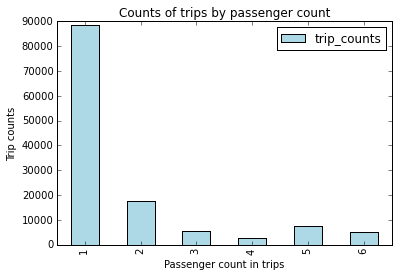

In [11]:
%%local
import matplotlib.pyplot as plt
%matplotlib inline

x_labels = sqlResults['passenger_count'].values
fig = sqlResults[['trip_counts']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(x_labels)
fig.set_title('Counts of trips by passenger count')
fig.set_xlabel('Passenger count in trips')
fig.set_ylabel('Trip counts')
plt.show()

#### Plot histogram of tip amount, relationship between tip amount vs. other features

In [12]:
%%sql -q -o sqlResults
SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train WHERE passenger_count > 0 AND passenger_count < 7 AND fare_amount > 0 AND fare_amount < 200 AND payment_type in ('CSH', 'CRD') AND tip_amount > 0 AND tip_amount < 25

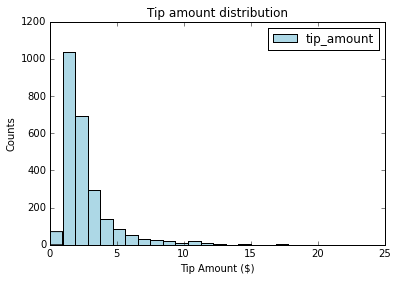

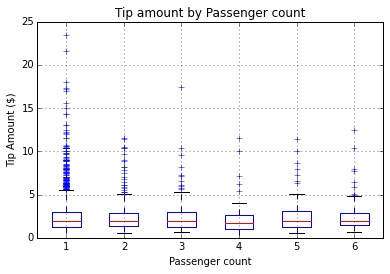

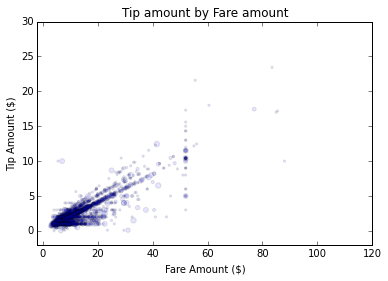

In [13]:
%%local
%matplotlib inline

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResults[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResults.boxplot(column=['tip_amount'], by=['passenger_count'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Tip Amount ($)')
plt.suptitle('')
plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResults.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=5*(sqlResults.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 120, -2, 30])
plt.show()

## Feature transformation and data prep for modeling

#### Create a new feature by binning hours into traffic time buckets

In [14]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """
    SELECT *,
    CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
taxi_df_train_with_newFeatures = sqlContext.sql(sqlStatement)

## CACHE DATA-FRAME IN MEMORY & MATERIALIZE DF IN MEMORY
taxi_df_train_with_newFeatures.cache()
taxi_df_train_with_newFeatures.count()

126050

#### Indexing and one-hot encoding of categorical features

Here we only transform three variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

In [15]:
timestart = datetime.datetime.now()

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, VectorIndexer

stringIndexer = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex")
model = stringIndexer.fit(taxi_df_train_with_newFeatures) # Input data-frame is the cleaned one from above
indexed = model.transform(taxi_df_train_with_newFeatures)
encoder = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec")
encoded1 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="rate_code", outputCol="rateIndex")
model = stringIndexer.fit(encoded1)
indexed = model.transform(encoded1)
encoder = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec")
encoded2 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="payment_type", outputCol="paymentIndex")
model = stringIndexer.fit(encoded2)
indexed = model.transform(encoded2)
encoder = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec")
encoded3 = encoder.transform(indexed)

stringIndexer = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex")
model = stringIndexer.fit(encoded3)
indexed = model.transform(encoded3)
encoder = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec")
encodedFinal = encoder.transform(indexed)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 2.45 seconds

#### Functions for creating labeledpoint RDD objects for input into logistic regression model, where categorical variables are included with one-hot encoding

Labeled point objects are particular RDD formatd that is needed as input data in most of MLlib's ML algorithms. In Labeled point objects, each observation is represented by a vector of features and the target label.

###### Functions for binary classification: tipped (/10) as binary target variable

In [16]:
from pyspark.mllib.regression import LabeledPoint
from numpy import array

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingBinary(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex,
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO LOGISTIC RERESSION MODELS
def parseRowOneHotBinary(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tipped, features)
    return  labPt

###### Functions for regression: tip amount ($) as target variable

In [17]:
# ONE-HOT ENCODING OF CATEGORICAL TEXT FEATURES FOR INPUT INTO TREE-BASED MODELS
def parseRowIndexingRegression(line):
    features = np.array([line.paymentIndex, line.vendorIndex, line.rateIndex, line.TrafficTimeBinsIndex, 
                         line.pickup_hour, line.weekday, line.passenger_count, line.trip_time_in_secs, 
                         line.trip_distance, line.fare_amount])
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt

# INDEXING CATEGORICAL TEXT FEATURES FOR INPUT INTO LINEAR REGRESSION MODELS
def parseRowOneHotRegression(line):
    features = np.concatenate((np.array([line.pickup_hour, line.weekday, line.passenger_count,
                                        line.trip_time_in_secs, line.trip_distance, line.fare_amount]), 
                                        line.vendorVec.toArray(), line.rateVec.toArray(), 
                                        line.paymentVec.toArray(), line.TrafficTimeBinsVec.toArray()), axis=0)
    labPt = LabeledPoint(line.tip_amount, features)
    return  labPt

#### Create a random sampling of the data, as needed (25% is used here). This can save some time while training models. Then, split into train/test, and create one-hot encoded or indexed train/test Labeled point data objects for input into MLlib

In [18]:
timestart = datetime.datetime.now()

# SPECIFY SAMPLING AND SPLITTING FRACTIONS
from pyspark.sql.functions import rand

samplingFraction = 0.25;
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;
encodedFinalSampled = encodedFinal.sample(False, samplingFraction, seed=seed)

# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
# INCLUDE RAND COLUMN FOR CREATING CROSS-VALIDATION FOLDS
dfTmpRand = encodedFinalSampled.select("*", rand(0).alias("rand"));
trainData, testData = dfTmpRand.randomSplit([trainingFraction, testingFraction], seed=seed);

## CACHE TRAIN AND TEST DATA
trainData.cache()
testData.cache()

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary = trainData.map(parseRowIndexingBinary)
indexedTESTbinary = testData.map(parseRowIndexingBinary)
oneHotTRAINbinary = trainData.map(parseRowOneHotBinary)
oneHotTESTbinary = testData.map(parseRowOneHotBinary)

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg = trainData.map(parseRowIndexingRegression)
indexedTESTreg = testData.map(parseRowIndexingRegression)
oneHotTRAINreg = trainData.map(parseRowOneHotRegression)
oneHotTESTreg = testData.map(parseRowOneHotRegression)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 0.25 seconds

#### Feature scaling can be important for some ML algos, e.g. regularized regressionons or SVMs. Here we show feature scaling for use with LinearRegressionwithSGD

In [19]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.util import MLUtils

# SCALE VARIABLES FOR REGULARIZED LINEAR SGD ALGO: We have found LinearRegressionWithSGD to be sensitive to feature scaling
label = oneHotTRAINreg.map(lambda x: x.label)
features = oneHotTRAINreg.map(lambda x: x.features)
scaler = StandardScaler(withMean=False, withStd=True).fit(features)
dataTMP = label.zip(scaler.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
oneHotTRAINregScaled = dataTMP.map(lambda x: LabeledPoint(x[0], x[1]))

label = oneHotTESTreg.map(lambda x: x.label)
features = oneHotTESTreg.map(lambda x: x.features)
scaler = StandardScaler(withMean=False, withStd=True).fit(features)
dataTMP = label.zip(scaler.transform(features.map(lambda x: Vectors.dense(x.toArray()))))
oneHotTESTregScaled = dataTMP.map(lambda x: LabeledPoint(x[0], x[1]))

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 10.46 seconds

#### Cache RDDs and DF Objects for faster running of algorithms with cached objects

In [20]:
timestart = datetime.datetime.now()

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary.cache();
indexedTESTbinary.cache();
oneHotTRAINbinary.cache();
oneHotTESTbinary.cache();

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg.cache();
indexedTESTreg.cache();
oneHotTRAINreg.cache();
oneHotTESTreg.cache();

# SCALED FEATURES
oneHotTRAINregScaled.cache();
oneHotTESTregScaled.cache();

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 0.13 seconds

## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

###### We address two learning problems
1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip
2. Regression problem: Prediction of the tip amonut ($)


Each model building setion will be split into steps: 
1. Model training data
2. Model evaluation on a test data set with metrics
3. Saving model in blob for future consumption

We show two ways to do cross-validation with parameter sweeping. In one, we provide a generic method for doing CV and parameter sweeping, which can be applied for any algorithm in MLlib, and for all parameter sets in an algorithm. In the other, we show the use of pySpark's CrossValidator pipeline function. Although convenient, based on our experience, CrossValidator has a few limitations for Spark 1.5.0, viz., 
1. Pipeline models cannot be saved/persisted for future consumption.
2. Cannot be used for every parameter in a model.
3. Cannot be used for every MLlib algorithm.

For each learning problem (binary classification or regression), we present a linear (logistic or linear regression) approach, followed by Random Forest and Boosted Trees.

### Logistic regression (LogisticRegressionWithLBFGS) with CV and hyperparameter sweeping. Includes evaluation of test data-set, and saving model for consumption

#### Custom CV code - which will generaize to all learnering algorithms in MLlib
NOTE: Execution of the following cell can take several minutes.

In [21]:
timestart = datetime.datetime.now()

from pyspark.mllib.classification import LogisticRegressionWithLBFGS 
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# CREATE PARAMETER GRID FOR LOGISTIC REGRESSION PARAMETER SWEEP
from sklearn.grid_search import ParameterGrid
grid = [{'regParam': [0.01, 0.1], 'iterations': [5, 10], 'regType': ["l1", "l2"], 'tolerance': [1e-3, 1e-4]}]
paramGrid = list(ParameterGrid(grid))
numModels = len(paramGrid)

# SET NUM FOLDS AND NUM PARAMETER SETS TO SWEEP ON
nFolds = 3;
h = 1.0 / nFolds;
metricSum = np.zeros(numModels);

# BEGIN CV WITH PARAMETER SWEEP
for i in range(nFolds):
    # Create training and x-validation sets
    validateLB = i * h
    validateUB = (i + 1) * h
    condition = (trainData["rand"] >= validateLB) & (trainData["rand"] < validateUB)
    validation = trainData.filter(condition)
    # Create labeled points from data-frames
    if i > 0:
        trainCVLabPt.unpersist()
        validationLabPt.unpersist()
    trainCV = trainData.filter(~condition)
    trainCVLabPt = trainCV.map(parseRowOneHotBinary)
    trainCVLabPt.cache()
    validationLabPt = validation.map(parseRowOneHotBinary)
    validationLabPt.cache()
    # For parameter sets compute metrics from x-validation
    for j in range(numModels):
        regt = paramGrid[j]['regType']
        regp = paramGrid[j]['regParam']
        iters = paramGrid[j]['iterations']
        tol = paramGrid[j]['tolerance']
        # Train logistic regression model with hypermarameter set
        model = LogisticRegressionWithLBFGS.train(trainCVLabPt, regType=regt, iterations=iters,  
                                                  regParam=regp, tolerance = tol, intercept=True)
        predictionAndLabels = validationLabPt.map(lambda lp: (float(model.predict(lp.features)), lp.label))
        # Use ROC-AUC as accuracy metrics
        validMetrics = BinaryClassificationMetrics(predictionAndLabels)
        metric = validMetrics.areaUnderROC
        metricSum[j] += metric

avgAcc = metricSum / nFolds;
bestParam = paramGrid[np.argmax(avgAcc)];

# Unpersist objects
trainCVLabPt.unpersist()
validationLabPt.unpersist()
    
# TRAIN ON FULL TRAIING SET USING BEST PARAMETERS FROM CV/PARAMETER SWEEP
logitBest = LogisticRegressionWithLBFGS.train(oneHotTRAINbinary, regType=bestParam['regType'], 
                                              iterations=bestParam['iterations'], 
                                              regParam=bestParam['regParam'], tolerance = bestParam['tolerance'], 
                                              intercept=True)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 142.78 seconds

#### Evaluate model with binary classification metrics, and plot ROC curve

In [22]:
timestart = datetime.datetime.now()

from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# PREDICT ON TEST DATA WITH BEST/FINAL MODEL
predictionAndLabels = oneHotTESTbinary.map(lambda lp: (float(logitBest.predict(lp.features)), lp.label))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)
# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)
metrics = MulticlassMetrics(predictionAndLabels)
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# OUTPUT PROBABILITIES AND REGISTER TEMP TABLE
logitBest.clearThreshold(); # This clears threshold for classification (0.5) and outputs probabilities
predictionAndLabelsDF = predictionAndLabels.toDF()
predictionAndLabelsDF.registerTempTable("tmp_results");

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under PR = 0.984753146176
Area under ROC = 0.982986767486
Summary Stats
Precision = 0.983655467635
Recall = 0.983655467635
F1 Score = 0.983655467635
Time taken to execute above cell: 2.63 seconds

In [23]:
%%sql -q -o sqlResults
SELECT * from tmp_results

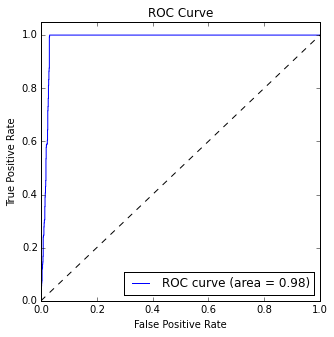

In [25]:
%%local
%matplotlib inline
from sklearn.metrics import roc_curve,auc

predictions_pddf = sqlResults.rename(columns={'_1': 'probability', '_2': 'label'})
prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf['label'], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Persist model in a blob with a date-stamp for future consumption

In [26]:
timestart = datetime.datetime.now()

from pyspark.mllib.classification import LogisticRegressionModel

datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
logisticregressionfilename = "LogisticRegressionWithLBFGS_" + datestamp;
dirfilename = modelDir + logisticregressionfilename;

logitBest.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds";

Time taken to execute above cell: 23.4 seconds

#### CV with parameter sweep using MLlib's CrossValidator function with LogisticRegression (Elastic regression) model
This code shows an example use of MLlib's CrossValidator pipeline function for CV with parameter sweep

NOTE: Execution of the following cell can take several minutes.

In [27]:
timestart = datetime.datetime.now()

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# Define algo / model
lr = LogisticRegression()

# Define grid parameters
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# Define CV with parameter sweep
cv = CrossValidator(estimator= lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(),
                    numFolds=3)

# Convert to data-frame, this won't run on RDDs
trainDataFrame = sqlContext.createDataFrame(oneHotTRAINbinary, ["features", "label"])

# Train with cross-validation
cv_model = cv.fit(trainDataFrame)


########################################
## PREDICT AND EVALUATE ON TEST DATA-SET
########################################
# Use Test data-set for prediction
testDataFrame = sqlContext.createDataFrame(oneHotTESTbinary, ["features", "label"])
predictionAndLabels = cv_model.transform(testDataFrame)

# Convert to DF and save register DF as table
predictionAndLabels.registerTempTable("tmp_results");

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds";

Time taken to execute above cell: 102.37 seconds
/usr/hdp/current/spark-client/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")

In [28]:
%%sql -q -o sqlResults
SELECT label, prediction, probability from tmp_results

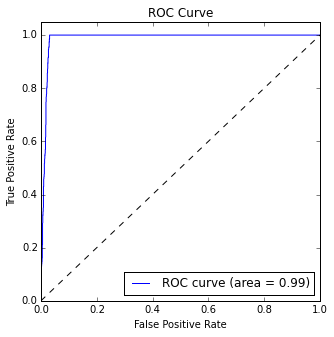

In [29]:
%%local
from sklearn.metrics import roc_curve,auc

prob = [x["values"][1] for x in sqlResults["probability"]]
fpr, tpr, thresholds = roc_curve(sqlResults['label'], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Random forest binary classification: modeling, evaluation, saving

In [30]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

# SPECIFY NUMBER OF CATEGORIES FOR CATEGORICAL FEATURES. FEATURE #0 HAS 2 CATEGORIES, FEATURE #2 HAS 2 CATEGORIES, AND SO ON
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}

# TRAIN RANDOMFOREST MODEL
rfModel = RandomForest.trainClassifier(indexedTRAINbinary, numClasses=2, 
                                       categoricalFeaturesInfo=categoricalFeaturesInfo,
                                       numTrees=25, featureSubsetStrategy="auto",
                                       impurity='gini', maxDepth=5, maxBins=32)
## UN-COMMENT IF YOU WANT TO PRING TREES
#print('Learned classification forest model:')
#print(rfModel.toDebugString())

# PREDICT ON TEST DATA AND EVALUATE
predictions = rfModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

# Area under ROC curve
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# PERSIST MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfclassificationfilename = "RandomForestClassification_" + datestamp;
dirfilename = modelDir + rfclassificationfilename;

rfModel.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under ROC = 0.984753146176
Time taken to execute above cell: 20.78 seconds

### Gradient boosting tree binary classification: modeling, evaluation, saving

In [31]:
timestart = datetime.datetime.now()

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

# SPECIFY NUMBER OF CATEGORIES FOR CATEGORICAL FEATURES. FEATURE #0 HAS 2 CATEGORIES, FEATURE #2 HAS 2 CATEGORIES, AND SO ON
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}

gbtModel = GradientBoostedTrees.trainClassifier(indexedTRAINbinary, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                                numIterations=10)
## UNCOMMENT IF YOU WANT TO PRINT TREE DETAILS
#print('Learned classification GBT model:')
#print(bgtModel.toDebugString())

# PREDICT ON TEST DATA AND EVALUATE
predictions = gbtModel.predict(indexedTESTbinary.map(lambda x: x.features))
predictionAndLabels = indexedTESTbinary.map(lambda lp: lp.label).zip(predictions)

# Area under ROC curve
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

# PERSIST MODEL IN A BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btclassificationfilename = "GradientBoostingTreeClassification_" + datestamp;
dirfilename = modelDir + btclassificationfilename;

gbtModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Area under ROC = 0.984753146176
Time taken to execute above cell: 13.87 seconds

## Regression model training: Predicting tip amount ($)

### Linear regression with stochastic gradient descent (SGD): modeling, evaluation, saving

NOTE: 
1. Cross-validation with Elastic Net for linear regression is given in Appendix.
2. In our experience, there can be frequent issues with convergance of LinearRegressionWithSGD models, and parameters need to be changed/optimized carefully for obtainig a valid model. Scaling of variables significantly helps (shown below). One can also use the elastic net regression which is shown below in the Appendix.

In [32]:
timestart = datetime.datetime.now()

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.mllib.evaluation import RegressionMetrics
from scipy import stats

# USE SCALED FEATURES TO TRAIN MODEL
linearModel = LinearRegressionWithSGD.train(oneHotTRAINregScaled, iterations=100, step = 0.1, regType='l2', regParam=0.1, intercept = True)

# SCORE ON SCALED TEST DATA-SET & EVALUATE
predictionAndLabels = oneHotTESTregScaled.map(lambda lp: (float(linearModel.predict(lp.features)), lp.label))
testMetrics = RegressionMetrics(predictionAndLabels)

print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
linearregressionfilename = "LinearRegressionWithSGD_" + datestamp;
dirfilename = modelDir + linearregressionfilename;

linearModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.33377864897
R-sqr = 0.585503152994
Time taken to execute above cell: 33.26 seconds

### Random Forest Regression: modeling, evaluation, saving

NOTE: Cross-validation with parameter sweeping using custom code is given in the appendix

In [33]:
timestart= datetime.datetime.now()

from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import RegressionMetrics


## TRAIN MODEL
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}
rfModel = RandomForest.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                    numTrees=25, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)
## UN-COMMENT IF YOU WANT TO PRING TREES
#print('Learned classification forest model:')
#print(rfModel.toDebugString())

## PREDICT AND EVALUATE ON TEST DATA-SET
predictions = rfModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = oneHotTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
rfregressionfilename = "RandomForestRegression_" + datestamp;
dirfilename = modelDir + rfregressionfilename;

rfModel.save(sc, dirfilename);

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.00996395626
R-sqr = 0.673021661896
Time taken to execute above cell: 21.85 seconds

### Gradient boosting trees regression: modeling, evaluation, saving

In [34]:
timestart= datetime.datetime.now()

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

## TRAIN MODEL
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}
gbtModel = GradientBoostedTrees.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo, 
                                                numIterations=10, maxBins=32, maxDepth = 4, learningRate=0.1)

## EVALUATE A TEST DATA-SET
predictions = gbtModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = indexedTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

# PLOT SCATTER-PLOT BETWEEN ACTUAL AND PREDICTED TIP VALUES
test_predictions = sqlContext.createDataFrame(predictionAndLabels)
test_predictions.registerTempTable("tmp_results");

# SAVE MODEL IN BLOB
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
btregressionfilename = "GradientBoostingTreeRegression_" + datestamp;
dirfilename = modelDir + btregressionfilename;
gbtModel.save(sc, dirfilename)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.01232323826
R-sqr = 0.669483122879
Time taken to execute above cell: 17.32 seconds

In [35]:
%%sql -q -o sqlResults
SELECT * from tmp_results

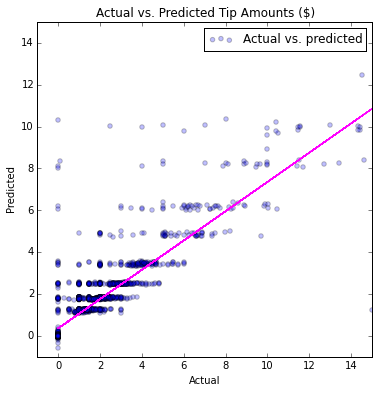

In [37]:
%%local
import numpy as np

ax = sqlResults.plot(kind='scatter', figsize = (6,6), x='_1', y='_2', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(sqlResults['_1'], sqlResults['_2'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.plot(sqlResults['_1'], fit[0] * sqlResults['_1'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

## APPENDIX: ADDITIONAL REGRESSION TASKS (CV WITH PARAMETER SWEEPING)

### Linear regression (Elastic net) using CrossValidator

In [38]:
timestart = datetime.datetime.now()

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define algo / model
lr = LinearRegression()

# Define grid parameters
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build() 

# Define pipeline, in this case, simply the modeling (without any transformations etc.)
pipeline = Pipeline(stages=[lr])

# Define CV with parameter sweep
cv = CrossValidator(estimator= lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(),
                    numFolds=3)

# Convert to data-frame, as CrossValidator won't run on RDDs
trainDataFrame = sqlContext.createDataFrame(oneHotTRAINreg, ["features", "label"])

# Train with cross-validation
cv_model = cv.fit(trainDataFrame)

timeend = datetime.datetime.now()
timeend-timestart

##########################################
## EVALUATE MODEL ON TEST SET
##########################################
testDataFrame = sqlContext.createDataFrame(oneHotTESTreg, ["features", "label"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
predictionAndLabels = cv_model.transform(testDataFrame)

# Convert to DF and save register DF as table
predictionAndLabels.registerTempTable("tmp_results");

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

Time taken to execute above cell: 150.69 seconds
/usr/hdp/current/spark-client/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")

In [39]:
%%sql -q -o sqlResults
SELECT label,prediction from tmp_results

In [40]:
%%local
from scipy import stats

corstats = stats.linregress(sqlResults['label'],sqlResults['prediction'])
r2 = (corstats[2]*corstats[2])
print("R-sqr = %s" % r2)

R-sqr = 0.564016585075


### Random Forest regression: CV with parameter sweep using custom code

In [41]:
timestart= datetime.datetime.now()

# GET ACCURARY FOR HYPERPARAMETERS VASED ON CROSS-VALIDATION IN TRAINING DATA-SET
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import RegressionMetrics
from sklearn.grid_search import ParameterGrid

## CREATE PARAMETER GRID
grid = [{'maxDepth': [5,10], 'numTrees': [25,50]}]
paramGrid = list(ParameterGrid(grid))

## SPECIFY LEVELS OF CATEGORICAL VARIBLES
categoricalFeaturesInfo={0:2, 1:2, 2:6, 3:4}

# Specify numfolds and array to hold metrics
nFolds = 3;
numModels = len(paramGrid)
h = 1.0 / nFolds;
metricSum = np.zeros(numModels);

for i in range(nFolds):
    # Create training and x-validation sets
    validateLB = i * h
    validateUB = (i + 1) * h
    condition = (trainData["rand"] >= validateLB) & (trainData["rand"] < validateUB)
    validation = trainData.filter(condition)
    # Create labeled points from data-frames
    if i > 0:
        trainCVLabPt.unpersist()
        validationLabPt.unpersist()
    trainCV = trainData.filter(~condition)
    trainCVLabPt = trainCV.map(parseRowIndexingRegression)
    trainCVLabPt.cache()
    validationLabPt = validation.map(parseRowIndexingRegression)
    validationLabPt.cache()
    # For parameter sets compute metrics from x-validation
    for j in range(numModels):
        maxD = paramGrid[j]['maxDepth']
        numT = paramGrid[j]['numTrees']
        # Train logistic regression model with hypermarameter set
        rfModel = RandomForest.trainRegressor(trainCVLabPt, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                    numTrees=numT, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=maxD, maxBins=32)
        predictions = rfModel.predict(validationLabPt.map(lambda x: x.features))
        predictionAndLabels = validationLabPt.map(lambda lp: lp.label).zip(predictions)
        # Use ROC-AUC as accuracy metrics
        validMetrics = RegressionMetrics(predictionAndLabels)
        metric = validMetrics.rootMeanSquaredError
        metricSum[j] += metric

avgAcc = metricSum/nFolds;
bestParam = paramGrid[np.argmin(avgAcc)];

# Unpersist objects
trainCVLabPt.unpersist()
validationLabPt.unpersist()
        
## TRAIN FINAL MODL WIHT BEST PARAMETERS
rfModel = RandomForest.trainRegressor(indexedTRAINreg, categoricalFeaturesInfo=categoricalFeaturesInfo,
                                    numTrees=bestParam['numTrees'], featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=bestParam['maxDepth'], maxBins=32)

## EVALUATE MODEL ON TEST DATA
predictions = rfModel.predict(indexedTESTreg.map(lambda x: x.features))
predictionAndLabels = indexedTESTreg.map(lambda lp: lp.label).zip(predictions)

testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds(), 2) 
print "Time taken to execute above cell: " + str(timedelta) + " seconds"; 

RMSE = 1.00698169839
R-sqr = 0.674480212537
Time taken to execute above cell: 66.47 seconds

## Cleanup objects from memory, print final time, and print model locations

#### Unpersist objects cached in memory

In [42]:
# REMOVE ORIGINAL DFs
taxi_df_train_cleaned.unpersist()
taxi_df_train_with_newFeatures.unpersist()
trainData.unpersist()
trainData.unpersist()

# FOR BINARY CLASSIFICATION TRAINING AND TESTING
indexedTRAINbinary.unpersist()
indexedTESTbinary.unpersist()
oneHotTRAINbinary.unpersist()
oneHotTESTbinary.unpersist()

# FOR REGRESSION TRAINING AND TESTING
indexedTRAINreg.unpersist()
indexedTESTreg.unpersist()
oneHotTRAINreg.unpersist()
oneHotTESTreg.unpersist()

# SCALED FEATURES
oneHotTRAINregScaled.unpersist()
oneHotTESTregScaled.unpersist()

PythonRDD[162] at RDD at PythonRDD.scala:43

#### Print out path to model files to be used in the consumption notebook
For consumption and scoring an independent data-set, you will need to copy and paste these file names in the "Consumption notebook".

In [43]:
## MODEL FILE LOCATIONS FOR CONSUMPTION
print "logisticRegFileLoc = modelDir + \"" + logisticregressionfilename + "\"";
print "linearRegFileLoc = modelDir + \"" + linearregressionfilename + "\"";
print "randomForestClassificationFileLoc = modelDir + \"" + rfclassificationfilename + "\"";
print "randomForestRegFileLoc = modelDir + \"" + rfregressionfilename + "\"";
print "BoostedTreeClassificationFileLoc = modelDir + \"" + btclassificationfilename + "\"";
print "BoostedTreeRegressionFileLoc = modelDir + \"" + btregressionfilename + "\"";

logisticRegFileLoc = modelDir + "LogisticRegressionWithLBFGS_2016-04-2523_40_16.087332"
linearRegFileLoc = modelDir + "LinearRegressionWithSGD_2016-04-2523_43_30.058765"
randomForestClassificationFileLoc = modelDir + "RandomForestClassification_2016-04-2523_42_39.585378"
randomForestRegFileLoc = modelDir + "RandomForestRegression_2016-04-2523_43_52.456436"
BoostedTreeClassificationFileLoc = modelDir + "GradientBoostingTreeClassification_2016-04-2523_42_55.680761"
BoostedTreeRegressionFileLoc = modelDir + "GradientBoostingTreeRegression_2016-04-2523_44_10.079694"

#### Print finish time

In [44]:
datetime.datetime.now()

datetime.datetime(2016, 4, 25, 23, 50, 8, 602433)